# Extraction
The fist step in MoSeq after data collection is to take the raw data and transform it into a representation that minmizes sources of variability that are not attributed to the animal's pose (e.g. it's location) and is less computationally expensive (i.e. less pixels). We accomplish this in the following steps:

1. Perform background subtraction such that the only positive pixels are those that are dynamic across time
2. Detect where the rat is in the frame using a segmentation network
3. Zero out all the pixels that are not attributed to the rat
4. Crop the frame around the rat
5. Rotate the rat so that it is always facing right 

This handles various sources of noise that might corrupt the data and impact your experiment. For instance, if you didn't crop the data, there would be a large amount of variance attributed to where the animal is in the arena, and MoSeq would learn syllables that are specific to the location of the animal. Next, if we didn't make sure the animal is always facing right MoSeq would learn syllables that are due to the animal flipping it's orientation due to our own error in orienting it. 

### Background subtraction

There are two ways to perform background extraction: 1.) take the median of each pixel across time or 2.) estimating a plane. Since we have depth data, we can accomplish the second by just estimating the plane that exists on the floor of the bucket. For azure data, only use the plane option. 

Once we subtract the background from the raw video, we get the distance of each pixel on the rat to the bucket floor.

In [6]:
from ratmoseq_extract.proc import get_bground
from ratmoseq_extract.io import read_frames
from pathlib import Path

pdir = Path('/n/groups/datta/jlove/data/rat_seq/rat_seq_paper/data/9weeks/scn2a/cohort13/session_20240725113325')

data = pdir / 'depth.avi'
# compute two different types of background
median, _ = get_bground(data, bground_type='median')
plane, _ = get_bground(data, bground_type='plane')
# load frames in
frames = read_frames(data, frames=range(100))
# subtract plane median from frames
subed = (plane - frames).astype('int16')
# threshold data (anything negative or over the height of the mouse that is expected is noise), 310 is usually a good maximum height
threshed = subed.copy()
threshed[threshed < 0] = 0
threshed[threshed > 310] = 0

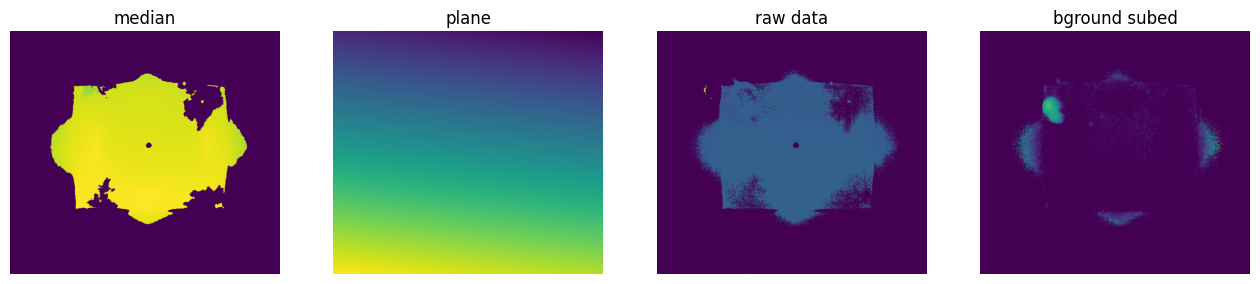

In [9]:
# use matplotlib for plotting
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 4, figsize=(16, 4))

ax[0].imshow(median)
ax[0].set_title('median')

ax[1].imshow(plane)
ax[1].set_title('plane')

ax[2].imshow(frames[0])
ax[2].set_title('raw data')

ax[3].imshow(threshed[0])
ax[3].set_title('bground subed')

for _ax in ax:
    _ax.axis('off')

### Rat detection 

Once we've succesfully subtracted the background, we then want to zero out any noise that doesn't have to do with the animal. We accomplish this through using Meta's Segment Anything 2 (sam2) model and keypoints detected using deeplabcut.

In [19]:
from ratmoseq_extract.sam2 import load_dlc, segment_chunk, get_sam2_predictor

dlc_path = pdir / 'ir_clippedDLC_resnet50_KeypointMoSeqDLCOct18shuffle1_50000.csv'
sam2_ckpt = '/n/groups/datta/jlove/data/sam2/checkpoints/sam2.1_hiera_tiny.pt'

# get DLC data
point = load_dlc(dlc_path, range(100))
# load the sam2 predictor
predictor = get_sam2_predictor(sam2_ckpt)
# get segmentation masks
mask, _ = segment_chunk(threshed, predictor, point)
# apply mask, mask is 1 where the rat is and 0 where it is not, so just multiply the two matrices
masked = threshed*mask

frame loading (JPEG): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.37it/s]
/n/groups/datta/jlove/data/sam2/sam2/sam2_video_predictor.py:786: UserWarning: cannot import name '_C' from 'sam2' (/n/groups/datta/jlove/data/sam2/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(
propagate in video: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.42it/s]


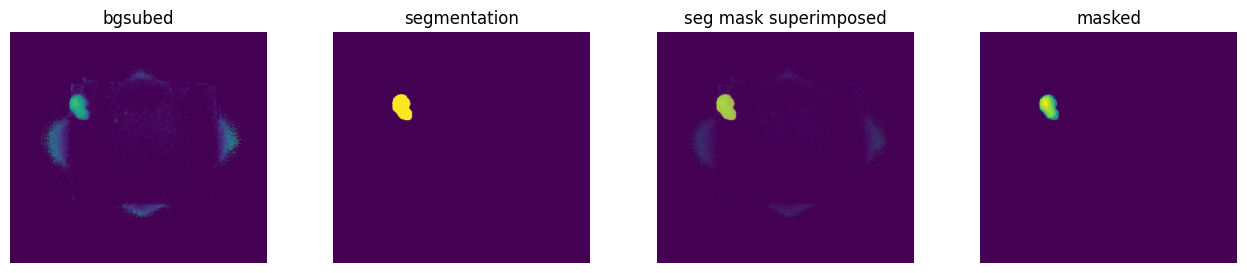

In [28]:
# use matplotlib for plotting
fig, ax = plt.subplots(1, 4, figsize=(16, 3))

ax[0].imshow(threshed[0])
ax[0].set_title('bgsubed')

ax[1].imshow(mask[0])
ax[1].set_title('segmentation')

ax[2].imshow(threshed[0])
ax[2].imshow(mask[0], alpha=.6)
ax[2].set_title('seg mask superimposed')


ax[3].imshow(masked[0])
ax[3].set_title('masked')

for _ax in ax:
    _ax.axis('off')

### Cropping and rotation

Now that we have the segmentation accomplished, let's go ahead and crop the frame to the center of the rat, and then rotate the rat so that it is always facing the same direction.

In [24]:
from ratmoseq_extract.proc import crop_and_rotate_frames, get_frame_features

In [29]:
# compute centroid and orientation
features = get_frame_features(masked)
# crop
cropped = crop_and_rotate_frames(masked, features, crop_size=(180, 180))

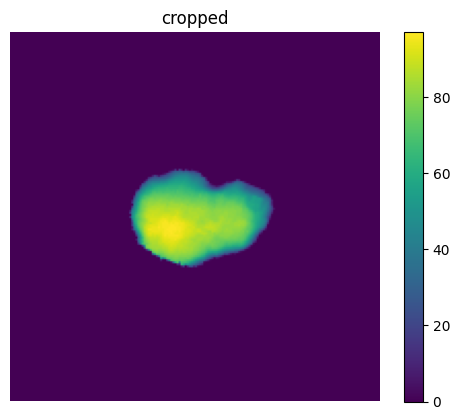

In [39]:
plt.imshow(cropped[0])
ax = plt.gca()
ax.axis('off');
ax.set_title('cropped');
plt.colorbar();

In [40]:
#TODO add moseq2-index bit

### Running it all using ratmoseq
Those are all the steps mentioned above, we can automate this by using the ratmoseq command line interface using the command below. After running it, you should find a `proc` directory in the same folder that has the `depth.avi` file you are pointing to. 

In [ ]:
!ratmoseq-extract extract depth.avi --sam2-checkpoint /path/to/sam2/checkpoints/sam2.1_hiera_tiny.pt \
--dlc-filename ir_clippedDLC_resnet50_KeypointMoSeqDLCOct18shuffle1_50000.csv --use-bground True --bground-type plane --num-frames 500